# Проект "Voice Emotion Recognition"

![](https://miro.medium.com/max/810/1*-5u1LG7fKmIwl2pSuJeSuA.jpeg)

# Команда участников:

### Бикметов Данил

### Гусейнов Саид

### Попов Дмитрий

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob
from sklearn.metrics import confusion_matrix
import IPython.display as ipd
import os
import sys
import warnings

plt.style.use('ggplot')
warnings.simplefilter("ignore")

# Загрузка данных

In [2]:
CREMA = "D:\CyberFace Project\Data\CREMA-D\\"

In [3]:
dir_list = os.listdir(CREMA)
dir_list.sort()
print(dir_list[0:10])

['1001_DFA_ANG_XX.wav', '1001_DFA_DIS_XX.wav', '1001_DFA_FEA_XX.wav', '1001_DFA_HAP_XX.wav', '1001_DFA_NEU_XX.wav', '1001_DFA_SAD_XX.wav', '1001_IEO_ANG_HI.wav', '1001_IEO_ANG_LO.wav', '1001_IEO_ANG_MD.wav', '1001_IEO_DIS_HI.wav']


In [4]:
gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in dir_list: 
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        emotion.append('female_neutral')
    else:
        emotion.append('Unknown')
    path.append(CREMA + i)
    
df = pd.DataFrame(emotion, columns = ['labels'])
df = pd.concat([df,pd.DataFrame(path, columns = ['path'])],axis=1)
df.labels.value_counts()

male_sad          671
male_disgust      671
male_angry        671
male_fear         671
male_happy        671
female_angry      600
female_fear       600
female_happy      600
female_disgust    600
female_sad        600
male_neutral      575
female_neutral    512
Name: labels, dtype: int64

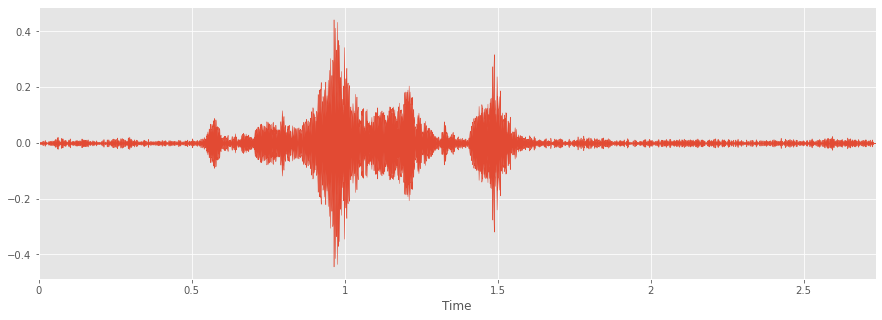

In [5]:
fname = CREMA + '1012_IEO_HAP_HI.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

ipd.Audio(fname)

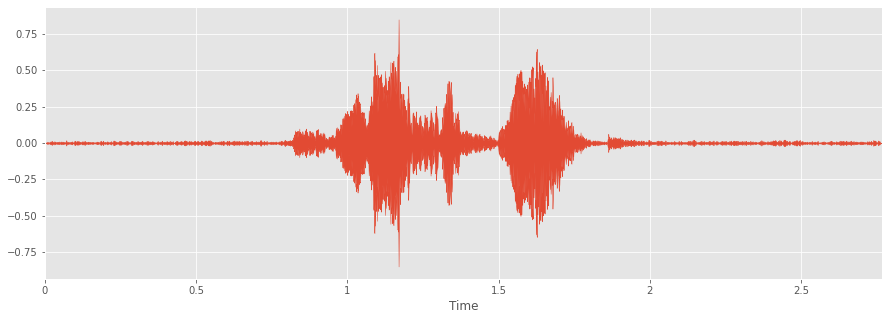

In [6]:
fname = CREMA + '1012_IEO_FEA_HI.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

ipd.Audio(fname)

In [7]:
df.head()

,labels,path
0,male_angry,D:\CyberFace Project\Data\CREMA-D\1001_DFA_ANG...
1,male_disgust,D:\CyberFace Project\Data\CREMA-D\1001_DFA_DIS...
2,male_fear,D:\CyberFace Project\Data\CREMA-D\1001_DFA_FEA...
3,male_happy,D:\CyberFace Project\Data\CREMA-D\1001_DFA_HAP...
4,male_neutral,D:\CyberFace Project\Data\CREMA-D\1001_DFA_NEU...


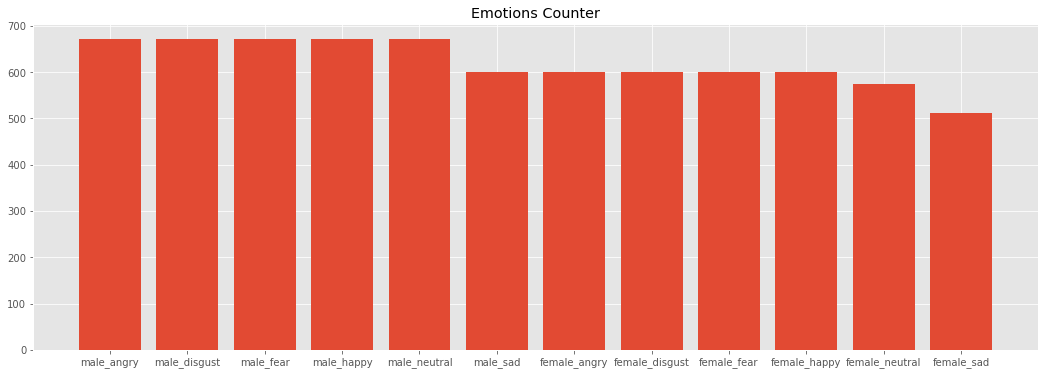

In [8]:
fig, ax = plt.subplots()
ax.bar(df.labels.unique(), df.labels.value_counts())
ax.set_title('Emotions Counter')

fig.set_figheight(6)
fig.set_figwidth(18)

### Визуализация

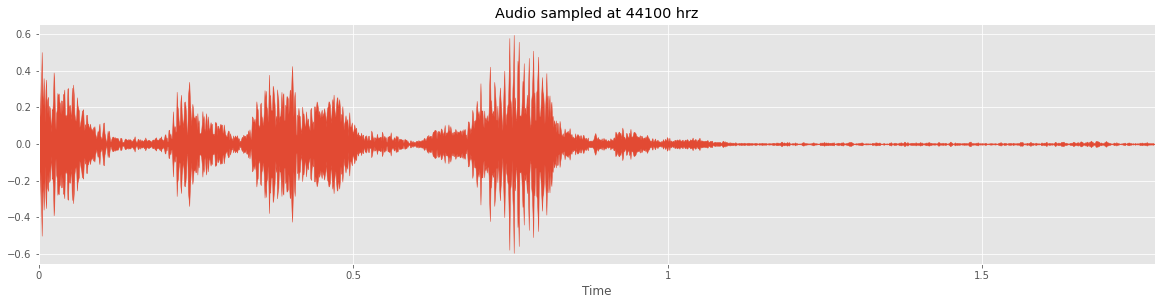

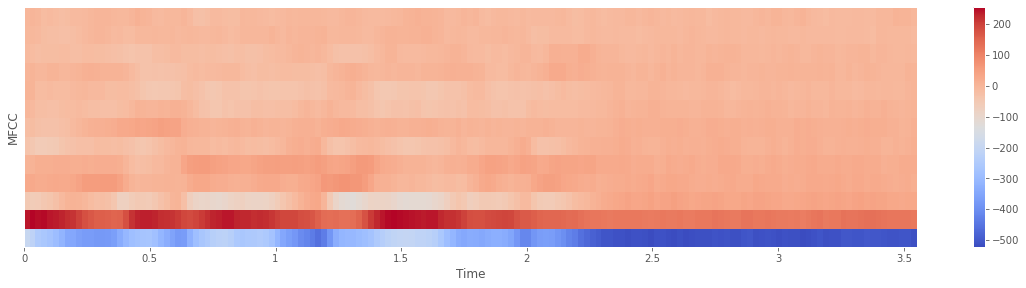

In [9]:
path = CREMA + '1001_DFA_ANG_XX.wav'
X, sample_rate = librosa.load(path, res_type='kaiser_fast', duration=2.5, sr=44100, offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

# Обработка признаков

In [10]:
def extract_voice_features(voice_folder, numcep=20, hop_length=256):
    voice_vectors = []
    indices = []
    for record_name in os.listdir(voice_folder):
        index = os.path.splitext(record_name)[0]
        indices.append(index)
        X, sr = librosa.load(os.path.join(voice_folder, record_name), sr=44100)
        mfcc_features = librosa.feature.mfcc(X, sr=sr, n_mfcc=numcep, hop_length=hop_length)
        voice_vector = mfcc_features.mean(axis=1)
        voice_vectors.append(voice_vector)
    return pd.DataFrame({
        'index': indices,
        'voice_vector': voice_vectors,
    })

In [11]:
%%time
vf = extract_voice_features(CREMA)

Wall time: 11min 41s


In [13]:
X = np.vstack(vf.voice_vector)
y = df.labels
X.shape, y.shape

((7442, 20), (7442,))

# Baseline
![](http://i1.hdslb.com/bfs/archive/ee8fdc7d5b93cc666bb43744ea44af118a93dcb8.jpg)

In [14]:
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

### Обработка данных

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

Нормируем признаки

In [16]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [17]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)

(5581, 20)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'male_angry' 'male_disgust' 'male_fear'
 'male_happy' 'male_neutral' 'male_sad']


In [18]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(5581, 20, 1)

### Моделирование

In [19]:
model = Sequential()
model.add(Conv1D(256, 8, padding='same', input_shape=(X_train.shape[1], 1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(MaxPooling1D(pool_size=(8), padding='same'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(MaxPooling1D(pool_size=(8), padding='same'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(12)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.00001)
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 20, 256)           2304      
_________________________________________________________________
activation (Activation)      (None, 20, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 256)           524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 256)           1024      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 256)           0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 256)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 256)            0

In [20]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_history = model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
349/349 [==============================] - 11s 27ms/step - loss: 2.4849 - accuracy: 0.0860 - val_loss: 2.4835 - val_accuracy: 0.1188
Epoch 2/100
349/349 [==============================] - 9s 26ms/step - loss: 2.4454 - accuracy: 0.1633 - val_loss: 2.4356 - val_accuracy: 0.1714
Epoch 3/100
349/349 [==============================] - 9s 26ms/step - loss: 2.4054 - accuracy: 0.1813 - val_loss: 2.3937 - val_accuracy: 0.1789
Epoch 4/100
349/349 [==============================] - 9s 26ms/step - loss: 2.3656 - accuracy: 0.1906 - val_loss: 2.3588 - val_accuracy: 0.1945
Epoch 5/100
349/349 [==============================] - 9s 26ms/step - loss: 2.3329 - accuracy: 0.2019 - val_loss: 2.3326 - val_accuracy: 0.2096
Epoch 6/100
349/349 [==============================] - 9s 26ms/step - loss: 2.3023 - accuracy: 0.2130 - val_loss: 2.2984 - val_accuracy: 0.2241
Epoch 7/100
349/349 [==============================] - 9s 26ms/step - loss: 2.2574 - accuracy: 0.2420 - val_loss: 2.2680 - val_accuracy

349/349 [==============================] - 10s 28ms/step - loss: 1.4412 - accuracy: 0.4647 - val_loss: 1.6686 - val_accuracy: 0.3837
Epoch 58/100
349/349 [==============================] - 10s 29ms/step - loss: 1.4561 - accuracy: 0.4673 - val_loss: 1.6609 - val_accuracy: 0.3939
Epoch 59/100
349/349 [==============================] - 11s 31ms/step - loss: 1.4178 - accuracy: 0.4899 - val_loss: 1.6722 - val_accuracy: 0.3853
Epoch 60/100
349/349 [==============================] - 11s 31ms/step - loss: 1.4172 - accuracy: 0.4871 - val_loss: 1.6517 - val_accuracy: 0.3907
Epoch 61/100
349/349 [==============================] - 11s 31ms/step - loss: 1.4226 - accuracy: 0.4691 - val_loss: 1.6594 - val_accuracy: 0.3960
Epoch 62/100
349/349 [==============================] - 10s 30ms/step - loss: 1.3944 - accuracy: 0.4957 - val_loss: 1.6728 - val_accuracy: 0.3890
Epoch 63/100
349/349 [==============================] - 11s 31ms/step - loss: 1.3832 - accuracy: 0.4855 - val_loss: 1.6537 - val_accuracy

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5581, 20, 1), (1861, 20, 1), (5581, 12), (1861, 12))

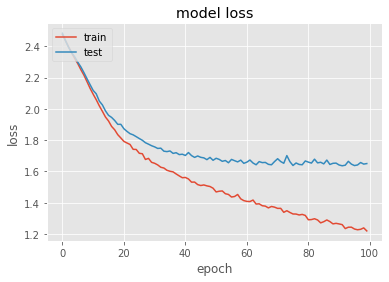

In [22]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Анализ модели

In [23]:
score = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 38.21%


In [24]:
preds = model.predict(X_test, batch_size=16, verbose=1)
preds=preds.argmax(axis=1)
preds

117/117 [==============================] - 1s 3ms/step


array([6, 7, 3, ..., 7, 0, 3], dtype=int64)

In [25]:
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))

actual = y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))

### Выведем матрицу ошибок:

In [26]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'

0.3820526598602902


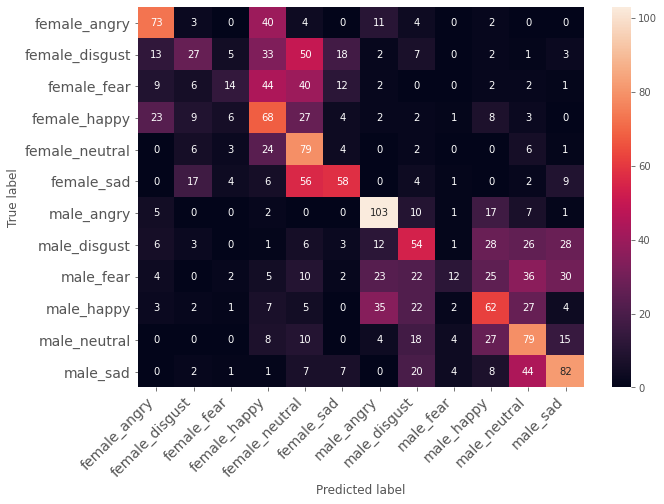

In [27]:
import seaborn as sns

classes = np.unique(actual)
classes.sort()

c = confusion_matrix(actual, preds)
print(accuracy_score(actual, preds))
print_confusion_matrix(c, class_names = classes)

In [28]:
classes = np.unique(actual)
classes.sort()
print(classification_report(actual, preds, target_names=classes))

                precision    recall  f1-score   support

  female_angry       0.54      0.53      0.53       137
female_disgust       0.36      0.17      0.23       161
   female_fear       0.39      0.11      0.17       132
  female_happy       0.28      0.44      0.35       153
female_neutral       0.27      0.63      0.38       125
    female_sad       0.54      0.37      0.44       157
    male_angry       0.53      0.71      0.61       146
  male_disgust       0.33      0.32      0.32       168
     male_fear       0.46      0.07      0.12       171
    male_happy       0.34      0.36      0.35       170
  male_neutral       0.34      0.48      0.40       165
      male_sad       0.47      0.47      0.47       176

      accuracy                           0.38      1861
     macro avg       0.40      0.39      0.36      1861
  weighted avg       0.40      0.38      0.36      1861



0.9016657710908114


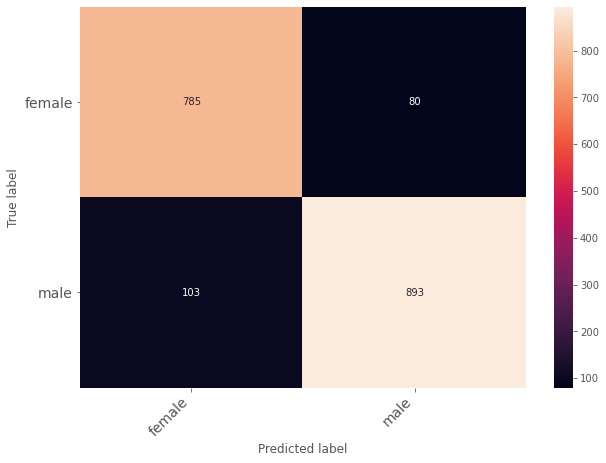

In [29]:
gender_actual = pd.Series(actual).replace({'female_angry':'female'
                                           , 'female_disgust':'female'
                                           , 'female_fear':'female'
                                           , 'female_happy':'female'
                                           , 'female_sad':'female'
                                           , 'female_surprise':'female'
                                           , 'female_neutral':'female'
                                           , 'male_angry':'male'
                                           , 'male_fear':'male'
                                           , 'male_happy':'male'
                                           , 'male_sad':'male'
                                           , 'male_surprise':'male'
                                           , 'male_neutral':'male'
                                           , 'male_disgust':'male'
                                          })

gender_preds = pd.Series(preds).replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = np.unique(gender_actual)
classes.sort() 

c = confusion_matrix(gender_actual, gender_preds)
print(accuracy_score(gender_actual, gender_preds))
print_confusion_matrix(c, class_names = classes)

# 2D CNN
![](https://hsto.org/webt/z0/nm/kz/z0nmkzn0tjfzyshnnlwss0b5b_4.png)

In [68]:
from tqdm import tqdm
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation, Input, Dense)

In [114]:
def prepare_data(df, n):
    X = np.empty(shape=(df.shape[0], n, 216, 1))
    input_length = 44100 * audio_duration
    
    cnt = 0
    for fname in tqdm(df.path):
        file_path = fname
        data, _ = librosa.load(file_path, sr=44100, res_type="kaiser_fast", duration=2.5, offset=0.5)
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length + offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, int(input_length) - len(data) - offset), "constant")
        MFCC = librosa.feature.mfcc(data, sr=44100, n_mfcc=n_mfcc)
        MFCC = np.expand_dims(MFCC, axis=-1)
        X[cnt,] = MFCC
        cnt += 1
    return X

In [115]:
def get_2d_conv_model(n):
    nclass = 12
    inp = Input(shape=(n,216,1))
    x = Convolution2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D(padding='same')(x)
    x = Dropout(rate=0.35)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D(padding='same')(x)
    x = Dropout(rate=0.35)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D(padding='same')(x)
    x = Dropout(rate=0.35)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D(padding='same')(x)
    x = Dropout(rate=0.35)(x)
    
    x = Flatten()(x)
    x = Dense(64)(x)
    x = Dropout(rate=0.35)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(rate=0.35)(x)
    
    out = Dense(nclass, activation=softmax)(x)
    model = models.Model(inputs=inp, outputs=out)
    
    opt = optimizers.Adam(0.005)
    # opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
    # opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

In [116]:
ref = df.copy()
audio_duration = 2.5
n_mfcc = 30
mfcc = prepare_data(ref, n = n_mfcc)

100%|██████████████████████████████████████████████████████████████████████████████| 7442/7442 [03:25<00:00, 36.18it/s]


In [117]:
X_train, X_test, y_train, y_test = train_test_split(mfcc, ref.labels, test_size=0.25, shuffle=True, random_state=42)

lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [118]:
model = get_2d_conv_model(n = n_mfcc)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=16, verbose=2, epochs=50)

Epoch 1/50
349/349 - 77s - loss: 2.3496 - acc: 0.1799 - val_loss: 2.2133 - val_acc: 0.1999
Epoch 2/50
349/349 - 78s - loss: 1.9686 - acc: 0.2867 - val_loss: 1.6958 - val_acc: 0.3724
Epoch 3/50
349/349 - 75s - loss: 1.8251 - acc: 0.3326 - val_loss: 1.8007 - val_acc: 0.3326
Epoch 4/50
349/349 - 67s - loss: 1.7250 - acc: 0.3528 - val_loss: 1.6473 - val_acc: 0.3869
Epoch 5/50
349/349 - 67s - loss: 1.6968 - acc: 0.3675 - val_loss: 1.5467 - val_acc: 0.4395
Epoch 6/50
349/349 - 68s - loss: 1.6559 - acc: 0.3774 - val_loss: 1.5319 - val_acc: 0.4352
Epoch 7/50
349/349 - 67s - loss: 1.6212 - acc: 0.3924 - val_loss: 1.6767 - val_acc: 0.3573
Epoch 8/50
349/349 - 66s - loss: 1.5828 - acc: 0.4098 - val_loss: 1.5255 - val_acc: 0.4132
Epoch 9/50
349/349 - 67s - loss: 1.5555 - acc: 0.4186 - val_loss: 1.4132 - val_acc: 0.4874
Epoch 10/50
349/349 - 67s - loss: 1.5314 - acc: 0.4259 - val_loss: 1.4839 - val_acc: 0.4465
Epoch 11/50
349/349 - 67s - loss: 1.5196 - acc: 0.4275 - val_loss: 1.4182 - val_acc: 0.47

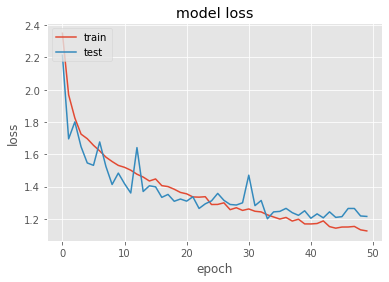

In [119]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [120]:
score = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

acc: 54.22%


In [121]:
preds = model.predict(X_test, batch_size=16, verbose=1)
preds=preds.argmax(axis=1)

117/117 [==============================] - 3s 26ms/step


In [122]:
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))

actual = y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))

0.5421816227834497


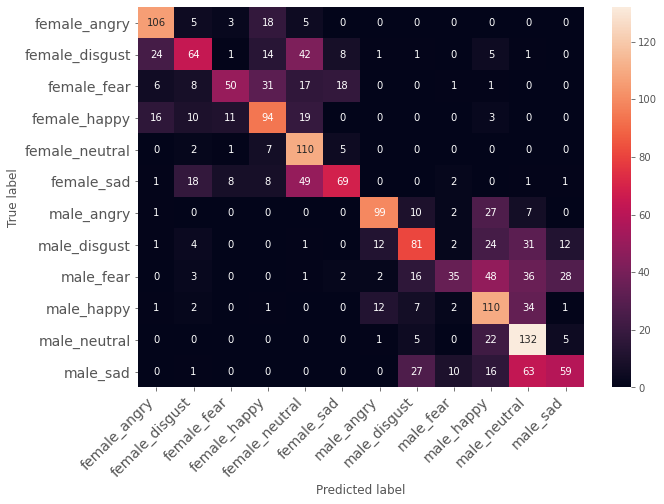

In [123]:
classes = np.unique(actual)
classes.sort()

c = confusion_matrix(actual, preds)
print(accuracy_score(actual, preds))
print_confusion_matrix(c, class_names = classes)

0.9811929070392262


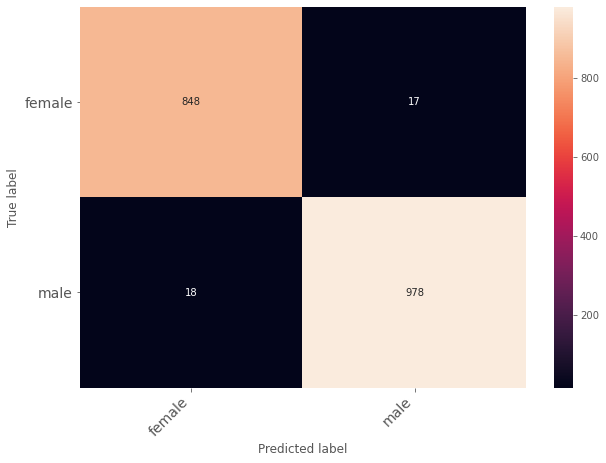

In [124]:
gender_actual = pd.Series(actual).replace({'female_angry':'female'
                                           , 'female_disgust':'female'
                                           , 'female_fear':'female'
                                           , 'female_happy':'female'
                                           , 'female_sad':'female'
                                           , 'female_surprise':'female'
                                           , 'female_neutral':'female'
                                           , 'male_angry':'male'
                                           , 'male_fear':'male'
                                           , 'male_happy':'male'
                                           , 'male_sad':'male'
                                           , 'male_surprise':'male'
                                           , 'male_neutral':'male'
                                           , 'male_disgust':'male'
                                          })

gender_preds = pd.Series(preds).replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = np.unique(gender_actual)
classes.sort() 

c = confusion_matrix(gender_actual, gender_preds)
print(accuracy_score(gender_actual, gender_preds))
print_confusion_matrix(c, class_names = classes)

# На этом всё, дорогие друзья!


![](https://myslide.ru/documents_7/8f53e5c727252722f969806feeb6bfc9/img44.jpg)